In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sns.set(style='ticks')

# Glasses Calibration Analyses
A set of analyses comparing calibration performance across 3 different models of wearable eye-trackers: Tobii Glasses 2, SMI, and Pupil Labs. Each tracker was tested on 3 different subjects. Each subject performed calibration tasks at 3 different distances (1M, 2M, and 3M). At each distance, calibration was tested at 3 different conditons of visual angle offset (-10deg, 0deg, +10deg). 

### Load the combined calibration summaries file
The calibration performance was summarized for each unique subject/glasses/distance/offset condition. These summarized files were combined into a single dataframe 

In [4]:
df = pd.read_table('./allSubjs_calibrationSummary.tsv', sep='\t')
df.head()

,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj,glasses,dist,offset,condition
0,1,15,1.983,872.513,456.424,0.683,408.041,0.113,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
1,2,21,1.992,178.414,736.665,1.135,443.071,0.074,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
2,3,3,1.983,529.483,128.252,0.564,412.494,0.114,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
3,4,13,1.975,537.017,401.570,1.226,429.390,0.123,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
4,5,25,1.983,862.071,709.513,1.481,436.933,0.087,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg


### average each condition across all calibration points
The dataset above has summarized each individual calibration pt (9 total) for each unique condition. Before any other analyses, average the calibration performance across these 9pts for each condition

In [5]:
df_cond = df.groupby('condition').mean()
df_cond.head()

,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj
condition,,,,,,,,,
101_PupilLabs_1M_0deg,5,13,1.984111,520.207333,412.236778,1.085667,435.041556,0.107333,101
101_PupilLabs_1M_10Ldeg,5,13,1.983000,461.427000,433.862778,1.266556,401.677222,0.159333,101
101_PupilLabs_1M_10Rdeg,5,13,1.896111,604.473444,413.189667,1.649778,394.174667,0.129778,101
101_PupilLabs_2M_0deg,5,13,1.984000,338.907444,381.451000,1.178778,503.402444,0.080111,101
101_PupilLabs_2M_10Ldeg,5,13,1.979444,188.118556,499.280444,1.841111,339.786333,0.102667,101


AttributeError: 'RangeIndex' object has no attribute 'split'

In [60]:
def splitConditions(row):
    print(row.name)
    

In [61]:
df_cond.apply(splitConditions, axis=1)

101_PupilLabs_1M_0deg
101_PupilLabs_1M_10Ldeg
101_PupilLabs_1M_10Rdeg
101_PupilLabs_2M_0deg
101_PupilLabs_2M_10Ldeg
101_PupilLabs_2M_10Rdeg
101_PupilLabs_3M_0deg
101_PupilLabs_3M_10Ldeg
101_PupilLabs_3M_10Rdeg
101_SMI_1M_0deg
101_SMI_1M_10Ldeg
101_SMI_1M_10Rdeg
101_SMI_2M_0deg
101_SMI_2M_10Ldeg
101_SMI_2M_10Rdeg
101_SMI_3M_0deg
101_SMI_3M_10Ldeg
101_SMI_3M_10Rdeg
101_Tobii_1M_0deg
101_Tobii_1M_10Ldeg
101_Tobii_1M_10Rdeg
101_Tobii_2M_0deg
101_Tobii_2M_10Ldeg
101_Tobii_2M_10Rdeg
101_Tobii_3M_0deg
101_Tobii_3M_10Ldeg
101_Tobii_3M_10Rdeg
102_PupilLabs_1M_0deg
102_PupilLabs_1M_10Ldeg
102_PupilLabs_1M_10Rdeg
102_PupilLabs_2M_0deg
102_PupilLabs_2M_10Ldeg
102_PupilLabs_2M_10Rdeg
102_PupilLabs_3M_0deg
102_PupilLabs_3M_10Ldeg
102_PupilLabs_3M_10Rdeg
102_SMI_1M_0deg
102_SMI_1M_10Ldeg
102_SMI_1M_10Rdeg
102_SMI_2M_0deg
102_SMI_2M_10Ldeg
102_SMI_2M_10Rdeg
102_SMI_3M_0deg
102_SMI_3M_10Ldeg
102_SMI_3M_10Rdeg
102_Tobii_1M_0deg
102_Tobii_1M_10Ldeg
102_Tobii_1M_10Rdeg
102_Tobii_2M_0deg
102_Tobii_2M_10Lde

condition
101_PupilLabs_1M_0deg      None
101_PupilLabs_1M_10Ldeg    None
101_PupilLabs_1M_10Rdeg    None
101_PupilLabs_2M_0deg      None
101_PupilLabs_2M_10Ldeg    None
101_PupilLabs_2M_10Rdeg    None
101_PupilLabs_3M_0deg      None
101_PupilLabs_3M_10Ldeg    None
101_PupilLabs_3M_10Rdeg    None
101_SMI_1M_0deg            None
101_SMI_1M_10Ldeg          None
101_SMI_1M_10Rdeg          None
101_SMI_2M_0deg            None
101_SMI_2M_10Ldeg          None
101_SMI_2M_10Rdeg          None
101_SMI_3M_0deg            None
101_SMI_3M_10Ldeg          None
101_SMI_3M_10Rdeg          None
101_Tobii_1M_0deg          None
101_Tobii_1M_10Ldeg        None
101_Tobii_1M_10Rdeg        None
101_Tobii_2M_0deg          None
101_Tobii_2M_10Ldeg        None
101_Tobii_2M_10Rdeg        None
101_Tobii_3M_0deg          None
101_Tobii_3M_10Ldeg        None
101_Tobii_3M_10Rdeg        None
102_PupilLabs_1M_0deg      None
102_PupilLabs_1M_10Ldeg    None
102_PupilLabs_1M_10Rdeg    None
                           ...

## Build a regression model to test influence of experimental vars
Build a model to see if accuracy (centDist) is influenced by:

* subj
* glasses
* dist
* offset
* ptIdx

In [8]:
from statsmodels.formula.api import ols

In [10]:
fullModel = ols("centDist ~ subj + glasses + dist + offset + ptIdx", df).fit()
print(fullModel.summary())

                            OLS Regression Results                            
Dep. Variable:               centDist   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.85
Date:                Tue, 30 May 2017   Prob (F-statistic):           1.94e-24
Time:                        14:38:53   Log-Likelihood:                -709.77
No. Observations:                 729   AIC:                             1438.
Df Residuals:                     720   BIC:                             1479.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.9304      2.983  

## Look at 0deg offest condition

Test whether calibration accuracy/precision varies across glasses at the 0deg offset condition

In [24]:
df_0deg = df[df.offset == '0deg']
df_0deg.shape

(243, 12)

#### center point (3,3) only 
First, look at calibration accuracy at 0deg offset based only on the center point in the calibration grid

In [26]:
df_0deg_center = df_0deg[df_0deg.ptIdx == 13]
df_0deg_center.shape

(27, 12)

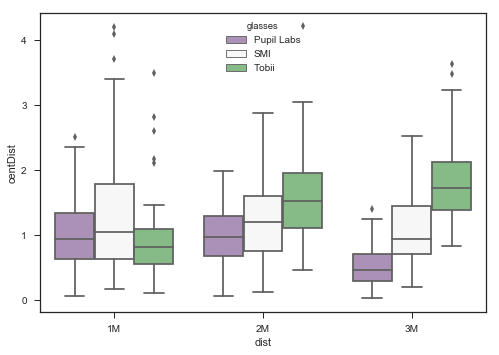

In [35]:
sns.boxplot(x="dist", y="centDist", hue="glasses", data=df, palette="PRGn")

In [32]:
df_0deg.head()

,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj,glasses,dist,offset
0,1,15,1.983,872.513,456.424,0.683,408.041,0.113,101,Pupil Labs,1M,0deg
1,2,21,1.992,178.414,736.665,1.135,443.071,0.074,101,Pupil Labs,1M,0deg
2,3,3,1.983,529.483,128.252,0.564,412.494,0.114,101,Pupil Labs,1M,0deg
3,4,13,1.975,537.017,401.570,1.226,429.390,0.123,101,Pupil Labs,1M,0deg
4,5,25,1.983,862.071,709.513,1.481,436.933,0.087,101,Pupil Labs,1M,0deg
